# Demonstration of the instability of likelihood-based training

In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import norm
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import plot_settings as ps


In [2]:
ps.setup()

## Models

In [3]:
def f(x):
    return 0.8* np.exp(- 3 * x**2) * (np.sin((x-0.5) * 0.5 * np.pi)) + 0.2 + 0.4*x


def logp(x, y):
    return np.log(
        0.6 * norm(loc=-0.1, scale=0.35).pdf(x)
        + 0.1 * norm(loc=0.67, scale=0.105).pdf(x)
        + 0.3 * norm(loc=0.2, scale=0.3).pdf(x)
    )


def sample(n, noise=0, cutoff=1.):
    x = np.concatenate((
        np.random.normal(loc=0, scale=0.5, size=int(n*0.3)),
        np.random.normal(loc=-0.1, scale=0.35, size=int(n*0.6)),
        np.random.normal(loc=0.67, scale=0.105, size=int(n*0.1)),
        np.random.normal(loc=0.2, scale=0.3, size=int(n*0.3)),
    ), axis=0)
    x = x[x**2 < cutoff**2]
    np.random.shuffle(x)
    y = f(x) + np.random.normal(loc=0., scale=noise, size=len(x))
    return x, y


## Generate data

In [4]:
n_data = 500
noise_data = 0
x_data, y_data = sample(n_data, noise_data)
z_data = np.zeros_like(x_data)


In [5]:
res_flm = 80

x_flm_curve = np.linspace(-1., 1., res_flm)
y_flm_curve = f(x_flm_curve)
z_flm_curve = np.exp(logp(x_flm_curve, y_flm_curve))

# Construct M-flow polygon data
flm_vertices = []
flm_probs = []
line_vertices = []
line_probs = []

for x0, y0, z0, x1, y1, z1 in zip(
    x_flm_curve[:-1], y_flm_curve[:-1], z_flm_curve[:-1], 
    x_flm_curve[1:], y_flm_curve[1:], z_flm_curve[1:]
):
    flm_vertices.append([(x0, y0, 0.), (x0, y0, z0), (x1, y1, z1), (x1, y1, 0.)])
    flm_probs.append(0.5*(z0 + z1))
    
    line_vertices.append([(x0, y0, z0), (x1, y1, z1)])
    line_probs.append(0.5*(z0 + z1))
    

In [6]:
axis_vertices = []
axis_probs = []

x0, y0 = 0.9, -0.8
zs = np.linspace(0., 1.05, 101)

for z0, z1 in zip(zs[:-1], zs[1:]):
    axis_vertices.append([(x0, y0, z0), (x0, y0, z1)])
    axis_probs.append(0.5*(z0 + z1))


## Plot

In [7]:
def cmap(vals, cmin = 0.0, cmax = 1.05, log=False):
    if log:
        vals = np.log(vals)
        cmin, cmax = np.log(cmin), np.log(cmax)
    return ps.CMAP(np.clip((vals - cmin) / (cmax - cmin), 0., 1.))


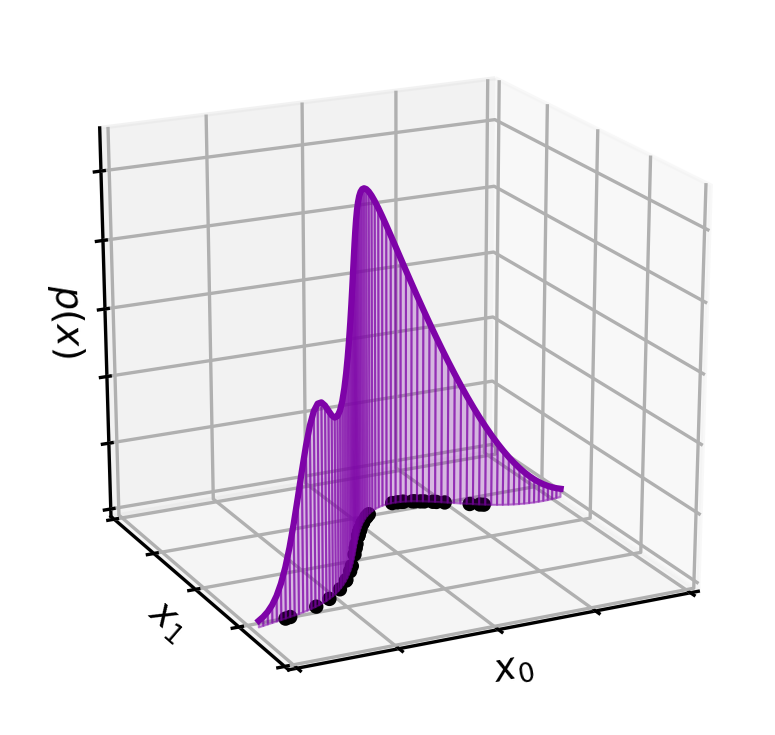

In [13]:
n_show = 40
xrange = (-1., 1.)
yrange = (-1., 1.)
zrange = (0., 1.1)

fig, ax = ps.figure(height=0.25*ps.TEXTWIDTH, cbar=False, make3d=True, large_margin=0.01, small_margin=0.01)

# Data points
ax.scatter(x_data[:n_show], y_data[:n_show], np.zeros(n_show), alpha=1., s=6., c=[ps.COLOR_NEUTRAL1])

# FLM density
poly = Poly3DCollection(
    flm_vertices,
    facecolors=[ps.add_transparency(ps.COLOR_FLMA, alpha=0.25) for _ in flm_vertices],
    edgecolors=[ps.add_transparency(ps.COLOR_FLMA, alpha=0.5) for _ in flm_vertices],
    lw=0.5
)
ax.add_collection3d(poly, zdir='z')
ax.plot(x_flm_curve, y_flm_curve, z_flm_curve, c=ps.COLOR_FLMA, lw=1.5)

# Axis ranges and view
ax.set_xlim3d(*xrange)
ax.set_ylim3d(*yrange)
ax.set_zlim3d(*zrange)
ax.view_init(20, 64)
ax.dist=9.

# Labels
ax.set_xlabel("$x_0$", labelpad=-15.)
ax.set_ylabel("$x_1$", labelpad=-15.)
ax.set_zlabel(r"$p(x)$", labelpad=-15.)
ax.set_xticklabels([""]*5)
ax.set_yticklabels([""]*5)
ax.set_zticklabels([""]*5)

plt.savefig("../figures/manifold_density_illustration_mf2.pdf")


In [12]:
def cmap(vals, cmin = 0.0, cmax = 1.1, log=False):
    if log:
        vals = np.log(vals)
        cmin, cmax = np.log(cmin), np.log(cmax)
    return ps.CMAP(np.clip((vals - cmin) / (cmax - cmin), 0., 1.))


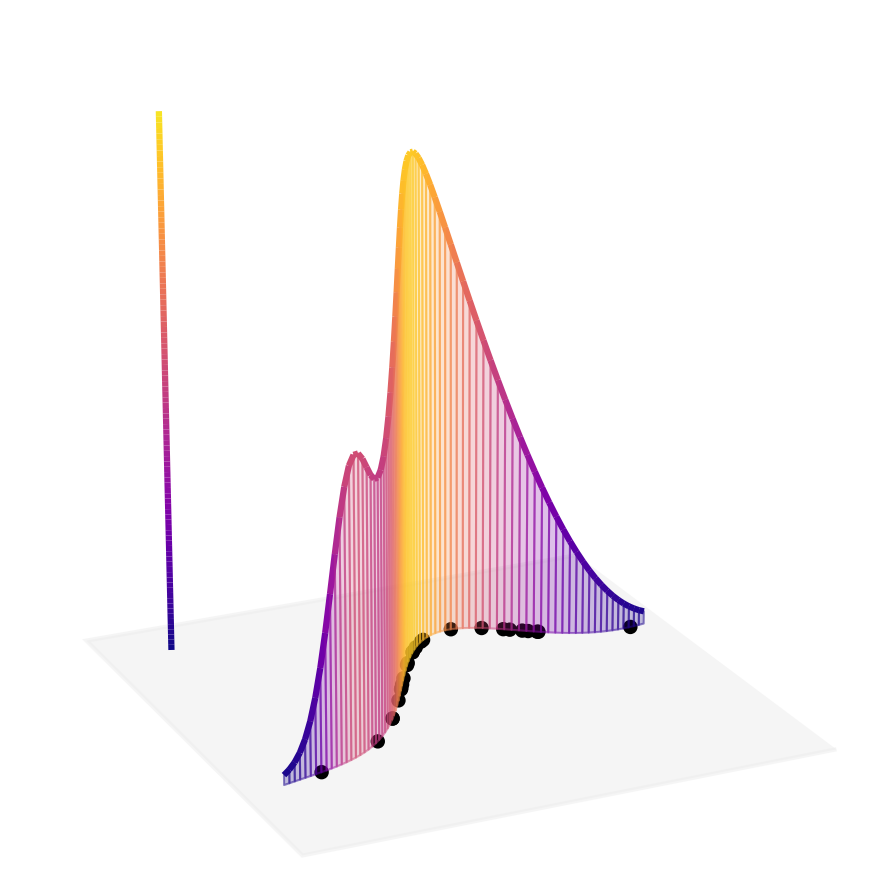

In [13]:
n_show = 25
xrange = (-1.1, 1.1)
yrange = (-1.1, 1.1)
zrange = (0., 1.)

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

# Density
poly = Poly3DCollection(
    flm_vertices,
    facecolors=[ps.add_transparency(cmap(c), alpha=0.25) for c in flm_probs],
    edgecolors=[ps.add_transparency(cmap(c), alpha=0.5) for c in flm_probs],
    lw=0.5
)
ax.add_collection3d(poly, zdir='z')

lines = Line3DCollection(line_vertices, colors=[cmap(c) for c in line_probs], lw=1.5)
ax.add_collection(lines)

# z axis
axis = Line3DCollection(axis_vertices, colors=[cmap(c) for c in axis_probs], lw=1.5)
ax.add_collection(axis)

# Data points
ax.scatter(x_data[:n_show], y_data[:n_show], np.zeros(n_show), alpha=1., s=6., c=[ps.COLOR_NEUTRAL1])

# Axis ranges and view
ax.view_init(20, 65)
ax.dist=8
ax.set_xlim3d(*xrange)
ax.set_ylim3d(*yrange)
ax.set_zlim3d(*zrange)

# Make panes transparent
ax.xaxis.pane.fill = False # Left pane
ax.yaxis.pane.fill = False # Right pane

# Remove grid lines
# ax.grid(False)

# Remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Transparent spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# No ticks
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])

plt.tight_layout()
plt.savefig("../figures/sketch_logo.png", dpi=600)


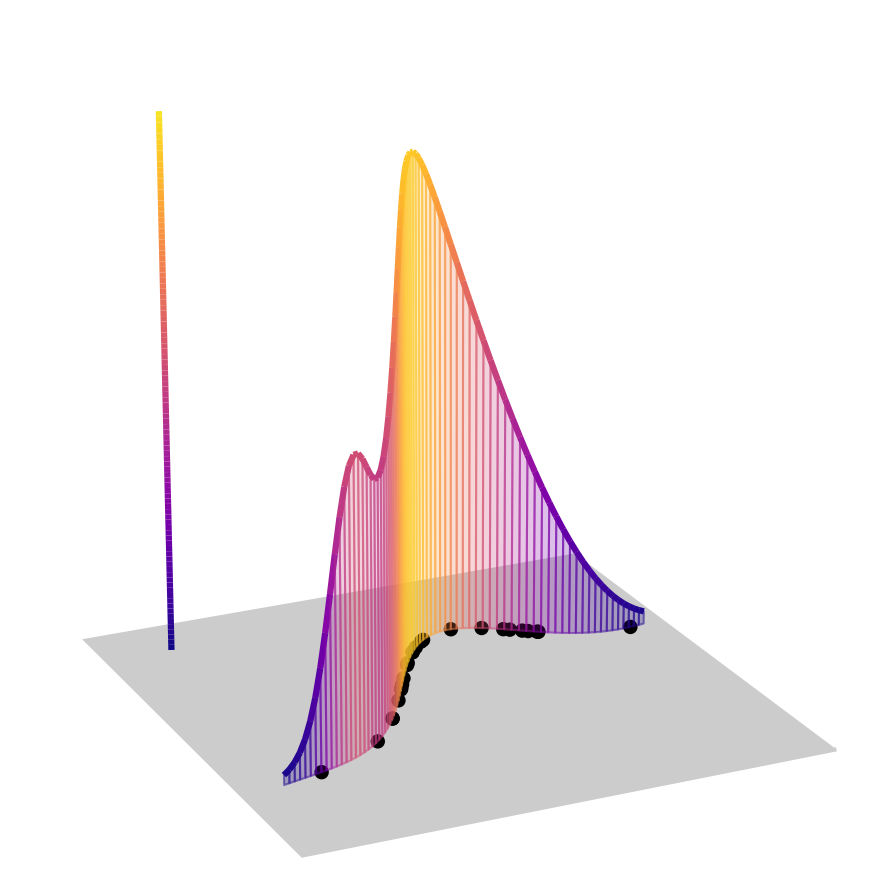

In [17]:
n_show = 25
xrange = (-1.1, 1.1)
yrange = (-1.1, 1.1)
zrange = (0., 1.)

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

# Density
poly = Poly3DCollection(
    flm_vertices,
    facecolors=[ps.add_transparency(cmap(c), alpha=0.25) for c in flm_probs],
    edgecolors=[ps.add_transparency(cmap(c), alpha=0.5) for c in flm_probs],
    lw=0.5
)
ax.add_collection3d(poly, zdir='z')

lines = Line3DCollection(line_vertices, colors=[cmap(c) for c in line_probs], lw=1.5)
ax.add_collection(lines)

# z axis
axis = Line3DCollection(axis_vertices, colors=[cmap(c) for c in axis_probs], lw=1.5)
ax.add_collection(axis)

# Data points
ax.scatter(x_data[:n_show], y_data[:n_show], np.zeros(n_show), alpha=1., s=6., c=[ps.COLOR_NEUTRAL1])

# Axis ranges and view
ax.view_init(20, 65)
ax.dist=8
ax.set_xlim3d(*xrange)
ax.set_ylim3d(*yrange)
ax.set_zlim3d(*zrange)

# Make panes transparent
ax.xaxis.pane.fill = False # Left pane
ax.yaxis.pane.fill = False # Right pane

# Remove grid lines
# ax.grid(False)

# Remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Transparent spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((0.8, 0.8, 0.8, 1.0))

# No ticks
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])

plt.tight_layout()
plt.savefig("../figures/sketch_logo_darker.png", dpi=600)


In [ ]:
n_show = 25
xrange = (-1.1, 1.1)
yrange = (-1.1, 1.1)
zrange = (0., 1.)

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

# Density
poly = Poly3DCollection(
    flm_vertices,
    facecolors=[ps.add_transparency(cmap(c), alpha=0.25) for c in flm_probs],
    edgecolors=[ps.add_transparency(cmap(c), alpha=0.5) for c in flm_probs],
    lw=0.5
)
ax.add_collection3d(poly, zdir='z')

lines = Line3DCollection(line_vertices, colors=[cmap(c) for c in line_probs], lw=1.5)
ax.add_collection(lines)

# z axis
axis = Line3DCollection(axis_vertices, colors=[cmap(c) for c in axis_probs], lw=1.5)
ax.add_collection(axis)

# Data points
ax.scatter(x_data[:n_show], y_data[:n_show], np.zeros(n_show), alpha=1., s=6., c=[ps.COLOR_NEUTRAL1])

# Axis ranges and view
ax.view_init(20, 65)
ax.dist=8
ax.set_xlim3d(*xrange)
ax.set_ylim3d(*yrange)
ax.set_zlim3d(*zrange)

# Make panes transparent
ax.xaxis.pane.fill = False # Left pane
ax.yaxis.pane.fill = False # Right pane

# Remove grid lines
# ax.grid(False)

# Remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Transparent spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# Transparent panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# No ticks
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])

plt.tight_layout()
plt.savefig("../figures/sketch_logo.png", dpi=600)
